In [ ]:
!pip install PyPDF2 textract 
!pip install -U pip setuptools wheel
!pip install -U spacy
!pip install jsonlines

import spacy.cli
spacy.cli.download("en_core_web_sm")

In [56]:
import textract
import PyPDF2

def extract_text_from_pdf(file):
    '''Opens and reads in a PDF file from path'''
    
    fileReader = PyPDF2.PdfFileReader(open(file,'rb'))
    page_count = fileReader.getNumPages()
    text = [fileReader.getPage(i).extractText() for i in range(page_count)]
    
    return str(text).replace("\\n", "")

def extract_text_from_word(filepath):
    '''Opens en reads in a .doc or .docx file from path'''
    
    txt = textract.process(filepath).decode('utf-8')
    
    return txt.replace('\n', ' ').replace('\t', ' ')

In [57]:
import en_core_web_sm
import os

# Load pre-trained Dutch language model
nlp = en_core_web_sm.load()

# File Extension. set as 'pdf' or as 'doc(x)'
extension = 'pdf'

def create_tokenized_texts_list(extension):
    '''read all cv files "pdf" or "docx" then tokenized them '''

    resume_texts, resume_names = [], [] #two variables to store the text of each file and its name
    
    # Loop over the contents of the directory containing the resumes, filtering by .pdf or .doc(x)
    for resume in list(filter(lambda x: extension in x, os.listdir('/content/drive/MyDrive/CV_matching/CV'))):
        if extension == 'pdf':
            # Read in every resume with pdf extension in the directory
            resume_texts.append(nlp(extract_text_from_pdf('/content/drive/MyDrive/CV_matching/CV/' + resume)))
        elif 'doc' in extension:
            # Read in every resume with .doc or .docx extension in the directory
            resume_texts.append(nlp(extract_text_from_word('/content/drive/MyDrive/CV_matching/CV/' + resume)))
            
        resume_names.append(resume.split('_')[0].capitalize())
        
    return resume_texts, resume_names #return two lists

In [ ]:
from spacy.pipeline import EntityRuler
from spacy import displacy
import jsonlines

# Create list store patterns to add it to new entity ruler 
with jsonlines.open("/content/drive/MyDrive/CV_matching/data/skill_patterns.jsonl") as f:
    pattern = [line for line in f.iter()]

# create list has just labels of all skills will use it in """visualize_entity_ruler(entity_list, doc) function """ to visualize extracted skills
with jsonlines.open("/content/drive/MyDrive/CV_matching/data/skill_patterns.jsonl") as f:
    created_entities = [line['label'].upper() for line in f.iter()]


#add new entity ruler to nlp pipeline
def add_newruler_to_pipeline():
    ruler = nlp.add_pipe("entity_ruler", after='parser')
    ruler.add_patterns(pattern)
    #print(nlp.pipeline)
    
#visualize the result of nlp model with just all available skills
def visualize_entity_ruler(entity_list, doc):
    '''Visualize the Skill entities of a doc'''
    colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
    options = {"ents": entity_list , "colors": colors}
    displacy.render(doc, style='ent',options =options , jupyter=True)


add_newruler_to_pipeline()#call function and add new ruler

doc,names = create_tokenized_texts_list(extension) # tokeniz the all CVs in the folder

visualize_entity_ruler(created_entities, doc)#call function and show visualization

In [63]:


def create_skill_set(doc):
    '''Create a set of the extracted skill entities of a doc'''
    
    return set([ent.label_.upper()[6:] for ent in doc.ents if 'skill' in ent.label_.lower()])



def create_skillset_dict(resume_names, resume_texts):
    '''Create a dictionary containing a set of the extracted skills. Name is key, matching skillset is value'''
    skillsets = [create_skill_set(resume_text) for resume_text in resume_texts]
    return dict(zip(resume_names, skillsets))

    
def required_skills_cv(extension):
    resume_texts, resume_names = [], []
    
    # Loop over the contents of the directory containing the resumes, filtering by .pdf or .doc(x)
    for resume in list(filter(lambda x: extension in x, os.listdir('/content/drive/MyDrive/CV_matching/required_skills'))):
        if extension == 'pdf':
            # Read in every resume with pdf extension in the directory
            resume_texts.append(nlp(extract_text_from_pdf('/content/drive/MyDrive/CV_matching/required_skills/' + resume)))
        elif 'doc' in extension:
            # Read in every resume with .doc or .docx extension in the directory
            resume_texts.append(nlp(extract_text_from_word('/content/drive/MyDrive/CV_matching/required_skills/' + resume)))
            
        resume_names.append(resume.split('_')[0].capitalize())
        
    return resume_texts, resume_names

def match_skills(vacature_set, cv_set, resume_name):
    '''Get intersection of resume skills and job offer skills and return match percentage'''
    
    if len(vacature_set) < 1:
        print('could not extract skills from job offer text')   
    else:
        pct_match = round(len(vacature_set.intersection(cv_set[resume_name])) / len(vacature_set) * 100, 0)
        print(resume_name + " has a {}% skill match on this job offer".format(pct_match))
        print('Required skills: {} '.format(vacature_set))
        print('Matched skills: {} \n'.format(vacature_set.intersection(skillset_dict[resume_name])))
        
        return (resume_name, pct_match)


resume_texts, resume_names = create_tokenized_texts_list(extension)
skillset_dict = create_skillset_dict(resume_names, resume_texts)

# example of job offer text (string). Can input your own.
vacature_text,name_cv = required_skills_cv(extension)

# Create a set of the skills extracted from the job offer text
vacature_skillset = create_skill_set(vacature_text[0])

# Create a list with tuple pairs containing the names of the candidates and their match percentage
match_pairs = [match_skills(vacature_skillset, skillset_dict, name) for name in skillset_dict.keys()]

Arafa arafa - cv.pdf has a 21.0% skill match on this job offer
Required skills: {'RECOMMENDER-SYSTEM', 'COMPUTER-SCIENCE', 'ARTIFICIAL-INTELLIGENCE', 'CERTIFICATE', 'KERAS', 'TENSORFLOW', 'BUSINESS', 'LANGUAGES', 'AZURE', 'TIME-SERIES', 'ENGINEERING', 'PYTORCH', 'GITHUB', 'AWS', 'DATA-SCIENCE', 'SQL', 'PYTHON', 'COMPUTER-VISION', 'DEEP-LEARNING', 'TABLEAU', 'MACHINE-LEARNING', 'ANALYTICS', 'DATA-ANALYSIS', 'POWERBI'} 
Matched skills: {'GITHUB', 'COMPUTER-SCIENCE', 'LANGUAGES', 'PYTHON', 'COMPUTER-VISION'} 

Sarah has a 100.0% skill match on this job offer
Required skills: {'RECOMMENDER-SYSTEM', 'COMPUTER-SCIENCE', 'ARTIFICIAL-INTELLIGENCE', 'CERTIFICATE', 'KERAS', 'TENSORFLOW', 'BUSINESS', 'LANGUAGES', 'AZURE', 'TIME-SERIES', 'ENGINEERING', 'PYTORCH', 'GITHUB', 'AWS', 'DATA-SCIENCE', 'SQL', 'PYTHON', 'COMPUTER-VISION', 'DEEP-LEARNING', 'TABLEAU', 'MACHINE-LEARNING', 'ANALYTICS', 'DATA-ANALYSIS', 'POWERBI'} 
Matched skills: {'RECOMMENDER-SYSTEM', 'COMPUTER-SCIENCE', 'ARTIFICIAL-INTELLIG

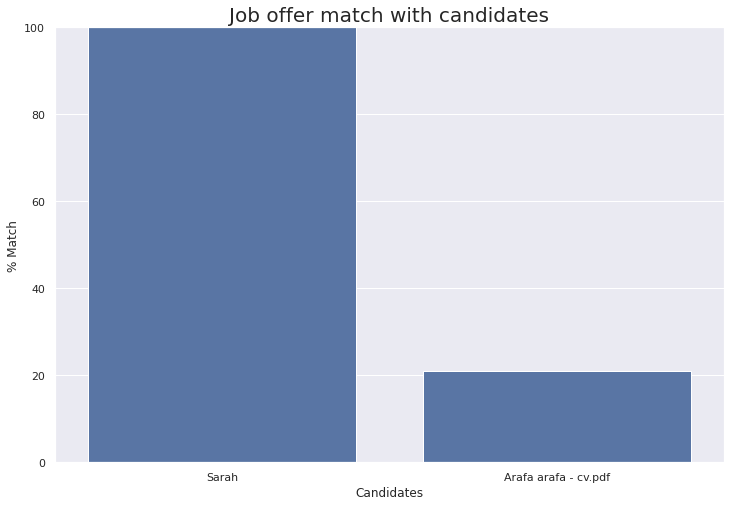

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

match_pairs.sort(key=lambda tup: tup[1], reverse=True)

# Unpack tuples
names, pct = zip(*match_pairs)

# Plotting
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Job offer match with candidates', fontsize=20)
ax.set(xlabel='Candidates', ylabel='% Match')
ax.set(ylim=(0, 100))


sns.set(font_scale=1.5)
sns.barplot(x=list(names), y=list(pct), color='b')

plt.show()